![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* analyse first-order (main effects) and total-order (total effects) indices of Sobol' using NSE as objective function
* analyse convergence of Sobol' indices
* assess Sobol' indices for multiple objective functions
* use the PAWN method

- - - 

# Tutorial 5d - Sensitivity analysis - Sobol and PAWN

- - -

## 1 Introduction

### 1.1 Sobol
Variance-Based Sensitivity Analysis (VBSA) is a general approach to sensitivity analysis that assesses the importance of input factors by decomposing the variance of the model output into components associated with individual factors and their interactions.

Steps in VBSA:
1. Generate Samples: Create a set of input samples, either randomly or using a specific sampling method. The number of samples should be sufficient to adequately represent the input parameter space.
2. Run Model Simulations: Evaluate the model for each set of input parameters from the generated samples. This involves running the model multiple times to obtain a corresponding set of output values.

3. Compute Total Variance: Calculate the total variance of the model output using all the simulated samples. This represents the overall variability in the model output across the entire parameter space.

4. Decompose Variance: Use statistical techniques, such as analysis of variance (ANOVA), to decompose the total variance into contributions from individual input parameters and their interactions. **Sobol' indices** are commonly employed for this decomposition. These indices quantify the proportion of the total variance that can be attributed to each input parameter, as well as their interactions:
* The **first-order** Sobol' index represents the proportion of the output variance attributable to the **main effect of an input parameter**.
* The **total** Sobol' index represents the contribution of the parameter to the total output variance, including both the **direct effect of the input parameter and any interactions with other input parameters**.

5. Ranking and Interpretation: Rank the Sobol' indices to identify the most influential input parameters. Higher indices indicate greater sensitivity. Interpret the results to understand which input parameters contribute the most to the variability in the model output.


The Sobol method requires quite a lot of samples (here, 3000 to start with). The script, thus, might
take a while to show a plot.

### 1.2 PAWN
PAWN (Plackett-Burman-based Additive Noise) is a sensitivity analysis method used to assess the impact of input variables on the output of a model. 

1. Design of Experiments: PAWN uses a Plackett-Burman experimental design, which is a type of fractional factorial design. The Plackett-Burman design allows for efficient sampling of the input space by selecting a subset of input combinations that capture the main effects of each variable.

2. Additive Noise: To enhance the robustness of the sensitivity analysis, PAWN introduces random noise into the model output. This is done by adding independent and identically distributed noise to the model response for each simulation. The noise helps in assessing the sensitivity of the model to changes in input variables, even in the presence of uncertainties and variability.

3. Sensitivity Indices: The sensitivity indices in PAWN are based on the comparison of conditional distributions of the model output. Specifically, it assesses the impact of input variables by considering the changes in the distribution of the model output for different levels of each input.vThe conditional cumulative distribution functions are used to quantify the sensitivity of the model to variations in each input variable.

4. Normalized Sensitivity Indices: PAWN provides normalized sensitivity indices that range between 0 and 1, indicating the relative importance of each input variable. These indices are normalized with respect to the variance of the model output.

5. Interpretation: High sensitivity indices suggest that the model output is significantly influenced by the corresponding input variable.

PAWN is particularly useful when dealing with models that have a high computational cost per simulation, as it allows for a more efficient exploration of the input space.

- - -

## 2 Using Sobol and PAWN

**Set current working directory and import python modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
sys.path.append('src/')
import EET # module to perform the EET
import plot_functions as pf # module to visualize the results
from sampling import AAT_sampling, AAT_sampling_extend # functions to perform the input sampling
from util import aggregate_boot # function to aggregate the bootstrap results
import HBV
import VBSA
import PAWN
# Supress warnings from numba
import logging
logger = logging.getLogger("numba")
logger.setLevel(logging.ERROR)
from ipywidgets import interact

def calc_nse(obs, sim):
    # Nash-Sutcliffe efficiency (NSE)
    # range: negative infinity to 1
    # optimal value: 1
    r_nse = np.corrcoef(obs, sim)[0][1] 
    alpha_nse = np.divide(np.std(sim), np.std(obs))
    beta_nse = np.divide(np.subtract(np.mean(sim), np.mean(obs)), np.std(obs))
    nse = 2 * alpha_nse * r_nse - np.square(alpha_nse) - np.square(beta_nse)
    return nse

def calc_rmse(obs, sim):
    return np.sqrt(np.mean((obs - sim)**2))

def calc_bias(obs, sim):
    return np.mean(np.subtract(obs, sim))

def calc_corr(obs, sim):
    return np.corrcoef(obs, sim)[0,1]

def hbv(par, precip, temp, evap):
    # Run HBV snow routine
    p_s, _, _ = HBV.snow_routine(par[:4], temp, precip)
    # Run HBV runoff simulation
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(par[4:], p_s, evap, Case, ini)
    return runoff_sim

def hbv_and_one_obj_fun(par, precip, temp, evap, runoff_obs, n_days, obj_fun):
    runoff_sim = hbv(par, precip, temp, evap)
    
    errors = obj_fun(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

def hbv_and_three_obj_fun(par, precip, temp, evap, runoff_obs, n_days, obj_fun1, obj_fun2, obj_fun3):
    runoff_sim = hbv(par, precip, temp, evap)
    
    errors = np.nan * np.ones((3,))
    errors[0] = obj_fun1(runoff_obs[n_days:], runoff_sim[n_days:])
    errors[1] = obj_fun2(runoff_obs[n_days:], runoff_sim[n_days:])
    errors[2] = obj_fun3(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

**Read catchment data**

In [2]:
# Read catchment data
catchment_name = "Siletz River, OR, USA"
file_dic = {catchment_name: "camels_14305500"}
df_obs = pd.read_csv(f"data/{file_dic[catchment_name]}.csv")
# Make sure the date is interpreted as a datetime object -> makes temporal operations easier
df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
# Index frame by date
df_obs.set_index('date', inplace=True)
# Select only the columns we need
df_obs = df_obs[["total_precipitation_sum","potential_evaporation_sum","streamflow", "temperature_2m_mean"]]
# Rename variables
df_obs.columns = ["P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]"]
# Select time frame
start_date = '2002-10-01'
end_date = '2005-09-30'
df_obs = df_obs[start_date:end_date]
# Reformat the date for plotting
df_obs["Date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))

# Prepare the time series intput
P = df_obs["P [mm/day]"].to_numpy()
PET = df_obs["PET [mm/day]"].to_numpy()
T = df_obs["T [C]"].to_numpy()
Q_obs = df_obs["Q [mm/day]"].to_numpy()

**Setup HBV**

In [3]:
n_spinup_days = 365

# define parameter names
parameter_names = ["Ts", "CFMAX", "CFR", "CWH", "BETA", "LP", "FC", "PERC", "K0", "K1", "K2", "UZL", "MAXBAS"]  
n_parameters = len(parameter_names)

# define marameter bounds
xmin = [-3, 0, 0, 0, 0, 0.3, 1, 0, 0.05, 0.01, 0.005, 0, 1]
xmax = [3, 20, 1, 0.8, 7, 1, 2000, 100, 2, 1, 0.1, 100, 6]

- - -

### 2.1 Using the Sobol method

#### 2.1.1 Analysing main effects, total effects and interactions

**Get samples**

In [16]:
# define distribution
distr_fun = st.uniform # uniform distribution
distr_par = [np.nan] * n_parameters
for i in range(n_parameters):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]
    
sampling_strategy = "lhs" # define the sampling strategy
n_samples = 250 #  Number of samples. For the tutorial we use 250, but you should rather use well over 1000 samples.

parameter_sets = AAT_sampling(sampling_strategy, n_parameters, distr_fun, distr_par, 2*n_samples)
parameter_sets_A, parameter_sets_B, parameter_sets_C = VBSA.vbsa_resampling(parameter_sets)

**Run the model and compute selected model output at sampled parameter sets**

In [5]:
print("Executing models (1/3): this might take a while")
errors_A = np.nan * np.ones(parameter_sets_A.shape[0]) 
for i, parameter_set_A in enumerate(parameter_sets_A):
    errors_A[i], _ = hbv_and_one_obj_fun(parameter_set_A, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Executing models (2/3): hang on")
errors_B = np.nan * np.ones(parameter_sets_B.shape[0]) 
for i, parameter_set_B in enumerate(parameter_sets_B):
    errors_B[i], _ = hbv_and_one_obj_fun(parameter_set_B, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Executing models (3/3): almost done")
errors_C = np.nan * np.ones(parameter_sets_C.shape[0]) 
for i, parameter_set_C in enumerate(parameter_sets_C):
    errors_C[i], _ = hbv_and_one_obj_fun(parameter_set_C, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Computing main (first-order) and total effects")
sobol_main, sobol_total = VBSA.vbsa_indices(errors_A, errors_B, errors_C, n_parameters)

Executing models (1/3): this might take a while
Executing models (2/3): hang on
Executing models (3/3): almost done
Computing main (first-order) and total effects


**Plot results**

In [6]:
print("Main effects, total effects and interactions in different plots:")
plt.figure(figsize=(25,15)) # plot main, total and interaction effects separately
plt.subplot(311)
pf.boxplot1(sobol_main, X_Labels=parameter_names, Y_Label='main effects')
plt.subplot(312)
pf.boxplot1(sobol_total, X_Labels=parameter_names, Y_Label='total effects')
plt.subplot(313)
pf.boxplot1(sobol_total-sobol_main, X_Labels=parameter_names, Y_Label='interactions')
plt.show()

Main effects, total effects and interactions in different plots:


**Use bootstrapping to derive confidence bounds**

Bootstrapping results: main effects, total effects and interactions in different plots, with confidence bounds:


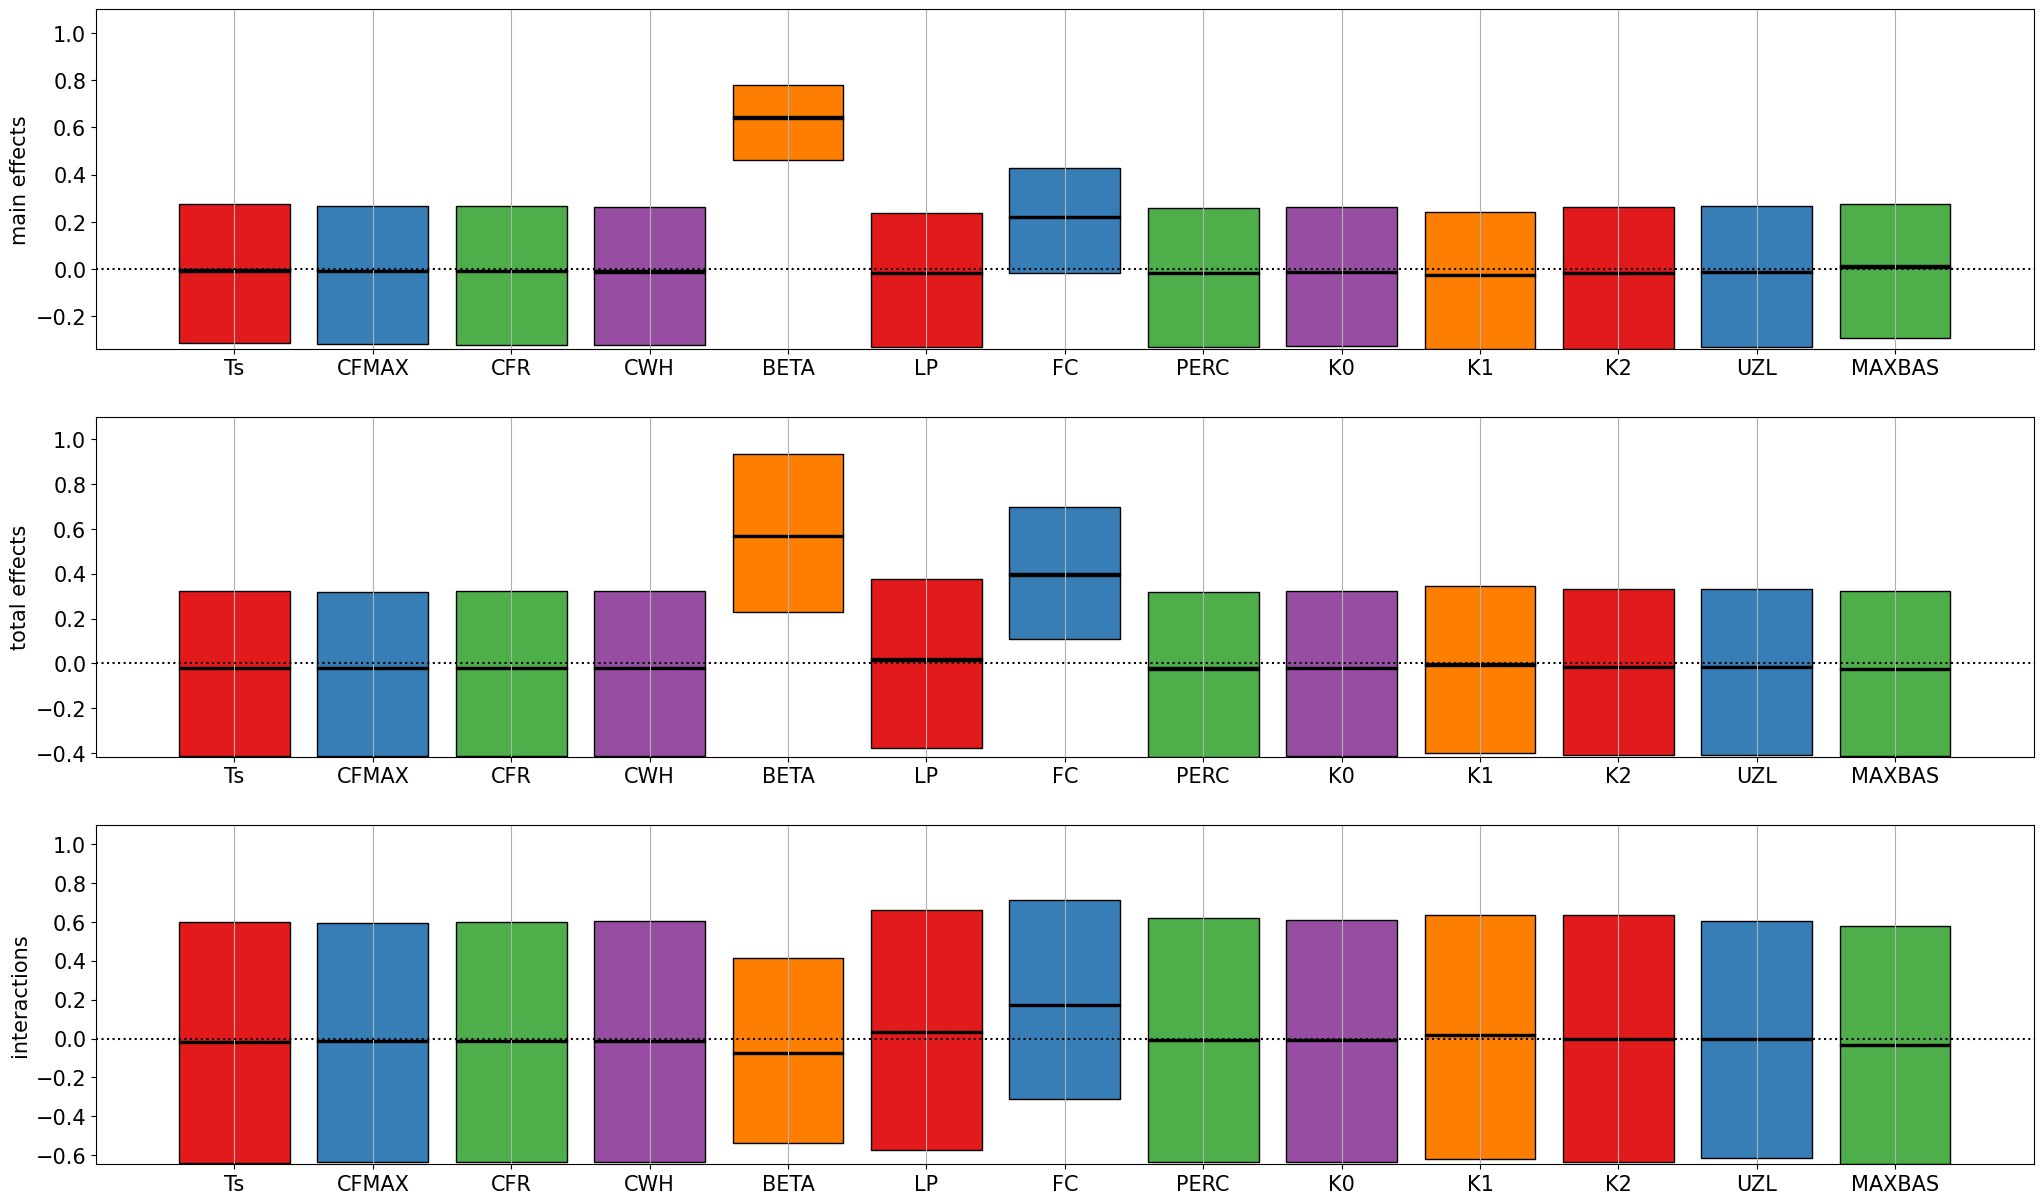

In [7]:
n_boot = 500  # bootstrap resample number
sobol_main_boot, sobol_total_boot = VBSA.vbsa_indices(errors_A, errors_B, errors_C, n_parameters, Nboot=n_boot)  # Compute sensitivity indices; each with shape (n_boot, n_parameters)
# Computing mean and confidence intervals of the sensitivity indices across the bootstrap resamples
sobol_main_m, sobol_main_lb, sobol_main_ub = aggregate_boot(sobol_main_boot) # shape (n_parameters,)
sobol_total_m, sobol_total_lb, sobol_total_ub = aggregate_boot(sobol_total_boot) # shape (n_parameters,)
sobol_inter_m, sobol_inter_lb, sobol_inter_ub = aggregate_boot(sobol_total_boot-sobol_main_boot) # shape (n_parameters,)

print("Bootstrapping results: main effects, total effects and interactions in different plots, with confidence bounds:")
plt.figure(figsize=(25,15)) # plot main, total and interaction effects separately
plt.subplot(311)
pf.boxplot1(sobol_main_m, S_lb=sobol_main_lb, S_ub=sobol_main_ub, X_Labels=parameter_names, Y_Label='main effects')
plt.subplot(312)
pf.boxplot1(sobol_total_m, S_lb=sobol_total_lb, S_ub=sobol_total_ub, X_Labels=parameter_names, Y_Label='total effects')
plt.subplot(313)
pf.boxplot1(sobol_inter_m, S_lb=sobol_inter_lb, S_ub=sobol_inter_ub, X_Labels=parameter_names, Y_Label='interactions')
plt.show()

---

<div class="blue"><span style="color:blue">Exercise section</span></div>
Exercise 1

a) According to the main effect, which parameter is most sensitive?

* Answer

b) According to the total effect, which parameter is most sensitive?

* Answer

c) Which parameter shows the most significant interactions?

* Answer

d) Looking at the confidence bounds: are you certain that your interpretation of the sensitivities is correct?

* Answer

---

#### 2.1.2 Analysing the convergence

**Analysing convergence using bootstrapping to derive confidence intervals**

[ 25  50  75 100 125 150 175 200 225 250]


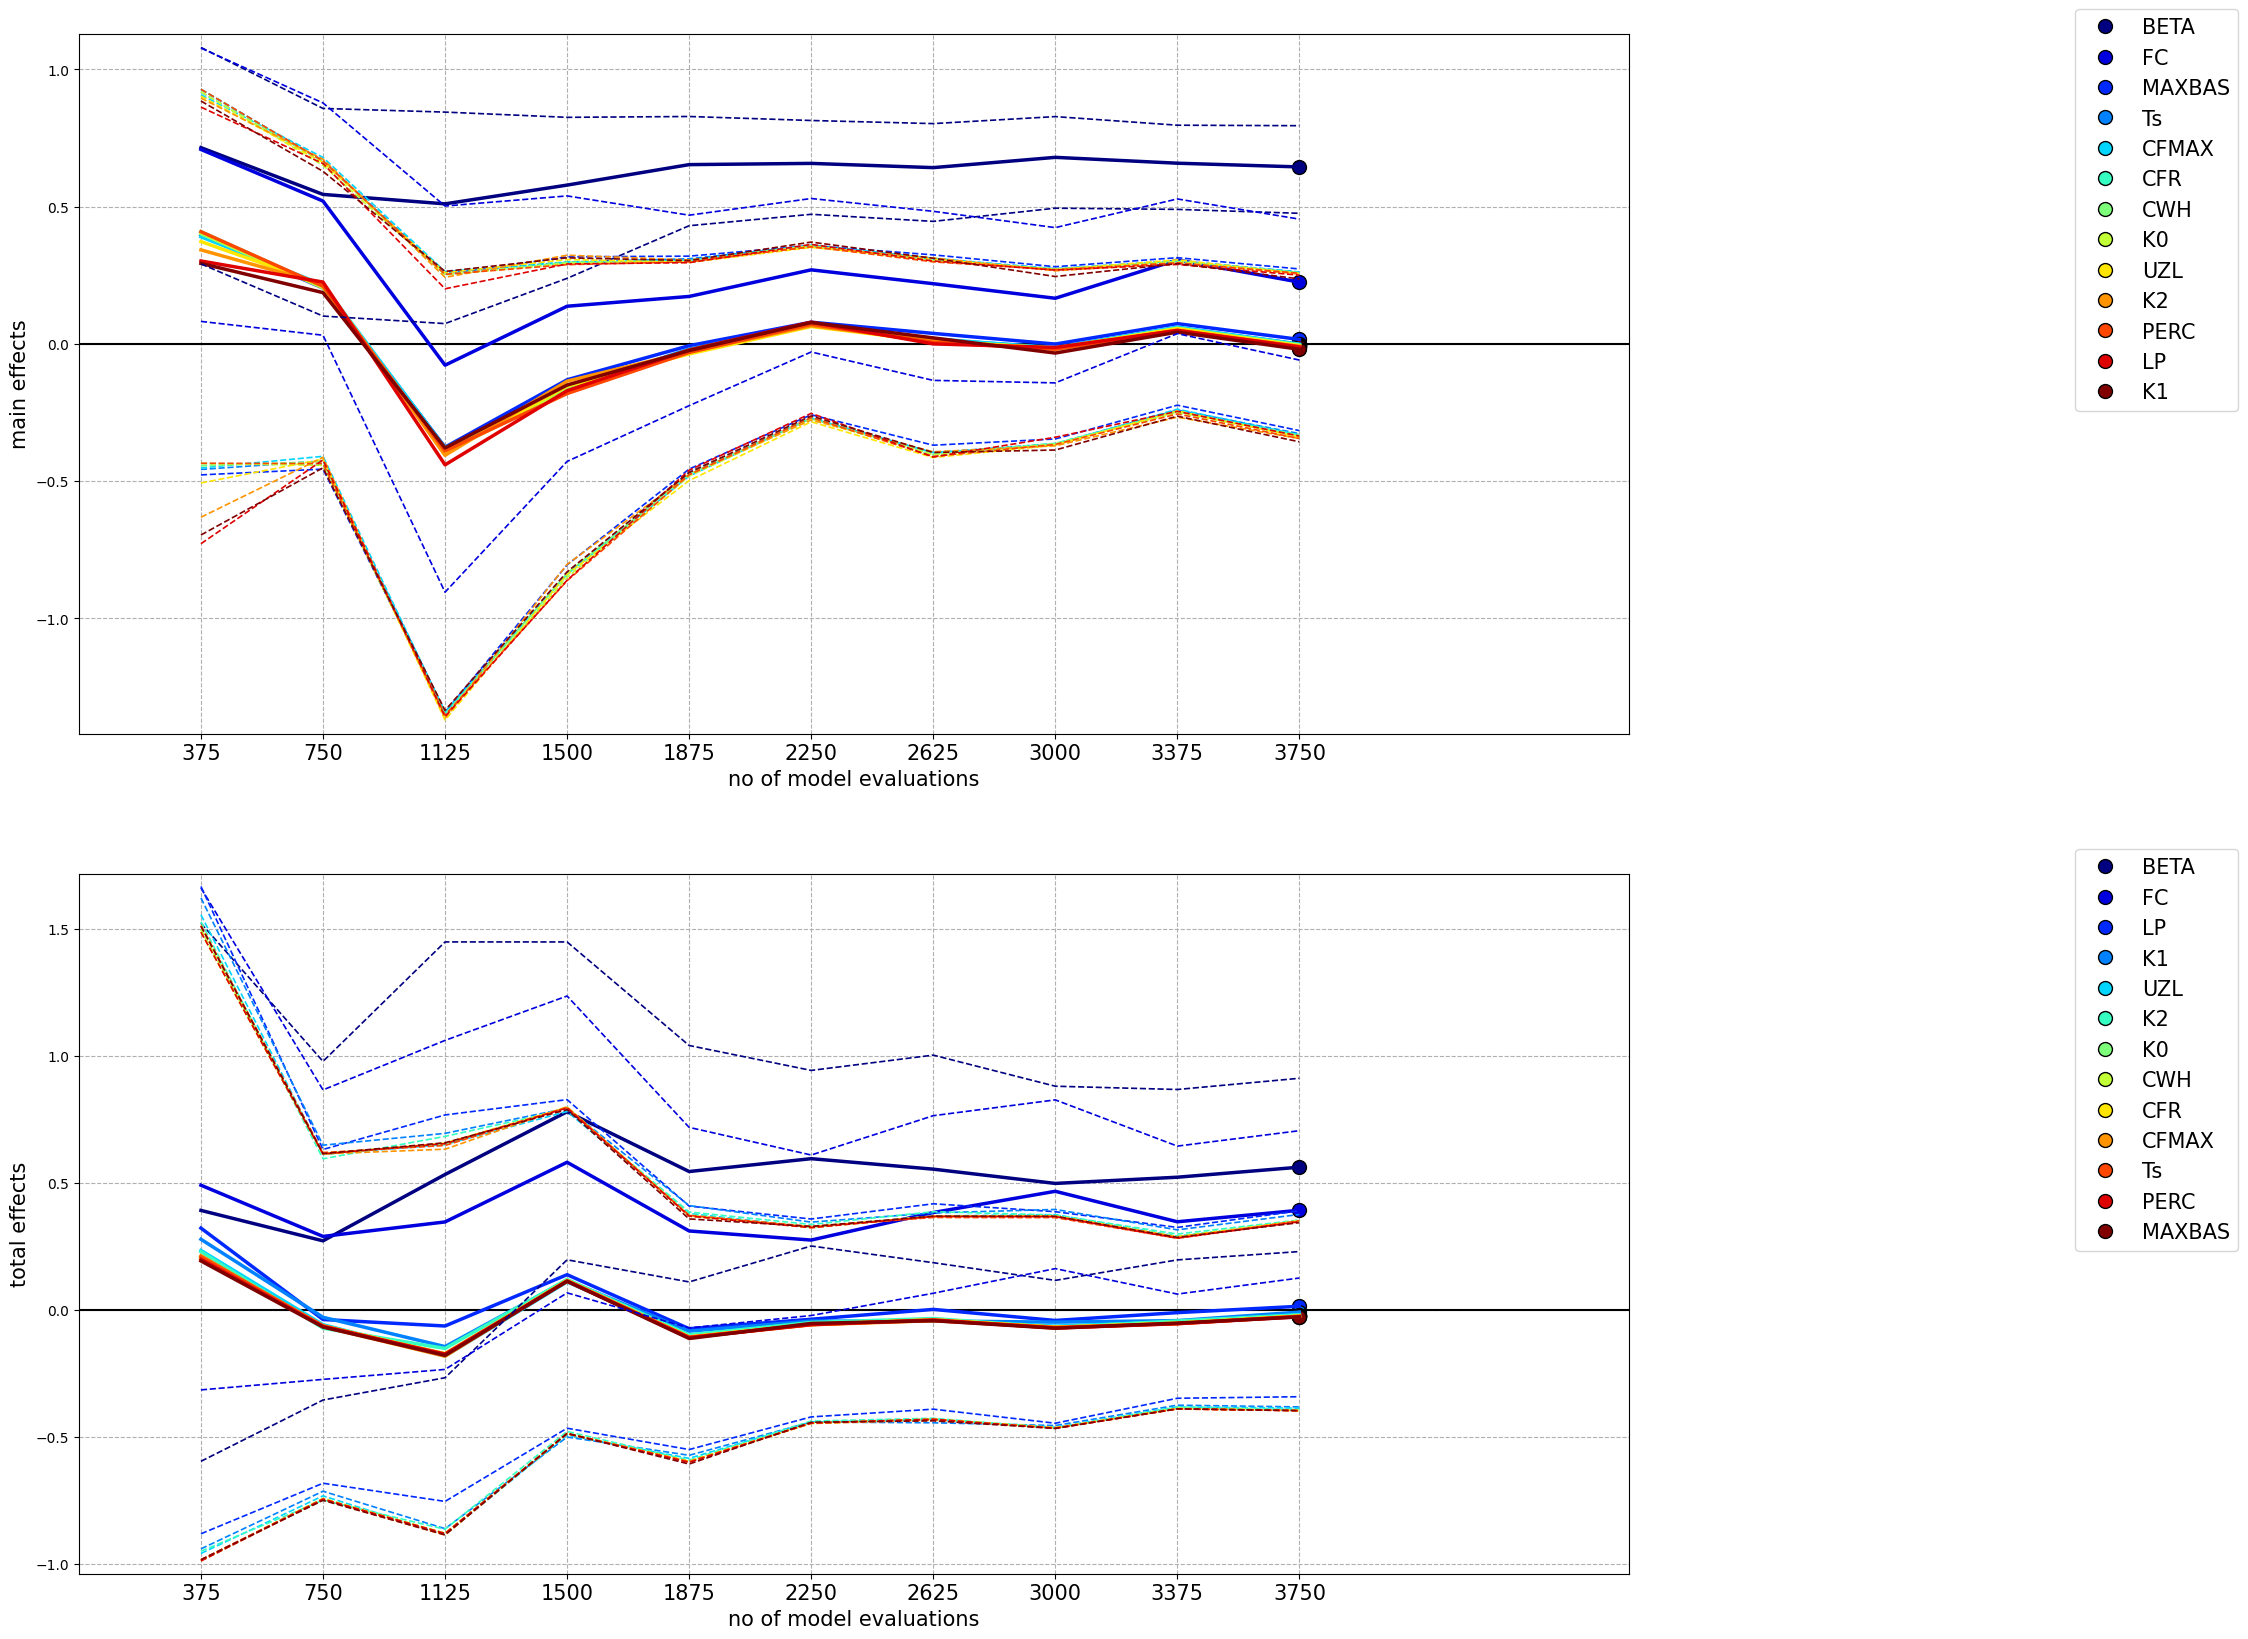

In [15]:
# define number of runs after which convergence should be checked
n_runs_conv_eval = np.linspace(n_samples/10, n_samples, 10).astype(int)
sobol_main_conv, sobol_total_conv = VBSA.vbsa_convergence(errors_A, errors_B, errors_C, n_parameters, n_runs_conv_eval, n_boot)
# Compute mean and confidence intervals of the sensitivity indices across the
# bootstrap resamples:
sobol_main_conv_m, sobol_main_conv_lb, sobol_main_conv_ub = aggregate_boot(sobol_main_conv)
sobol_total_conv_m, sobol_total_conv_lb, sobol_total_conv_ub = aggregate_boot(sobol_total_conv)

# Plot convergence results:
plt.figure(figsize=(20,20))
plt.subplot(211)
pf.plot_convergence(sobol_main_conv_m, n_runs_conv_eval*(n_parameters+2), sobol_main_conv_lb, sobol_main_conv_ub,
                    X_Label='no of model evaluations',
                    Y_Label='main effects', labelinput=parameter_names)
plt.subplot(212)
pf.plot_convergence(sobol_total_conv_m, n_runs_conv_eval*(n_parameters+2), sobol_total_conv_lb, sobol_total_conv_ub,
                    X_Label='no of model evaluations',
                    Y_Label='total effects', labelinput=parameter_names)
plt.show()

---

<div class="blue"><span style="color:blue">Exercise section</span></div>
Exercise 2

a) Describe how the sensitivity changes with sample size. How does the ranking of sensitivity change with sample size?
* Answer

b) How do the convergence bounds change with sample size?

* Answer

---

#### 2.1.3 Increasing the sample size

**Resample with extended sample size**

Resampling using extended set of samples
Executing models (1/3): this might take a while
Executing models (2/3): wait
Executing models (3/3): almost done
Combining new and old results
Recomputing indices with bootstrap
Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples
Sensitivity indices calculated with the initial sample size (left) and the extended sample size (right)


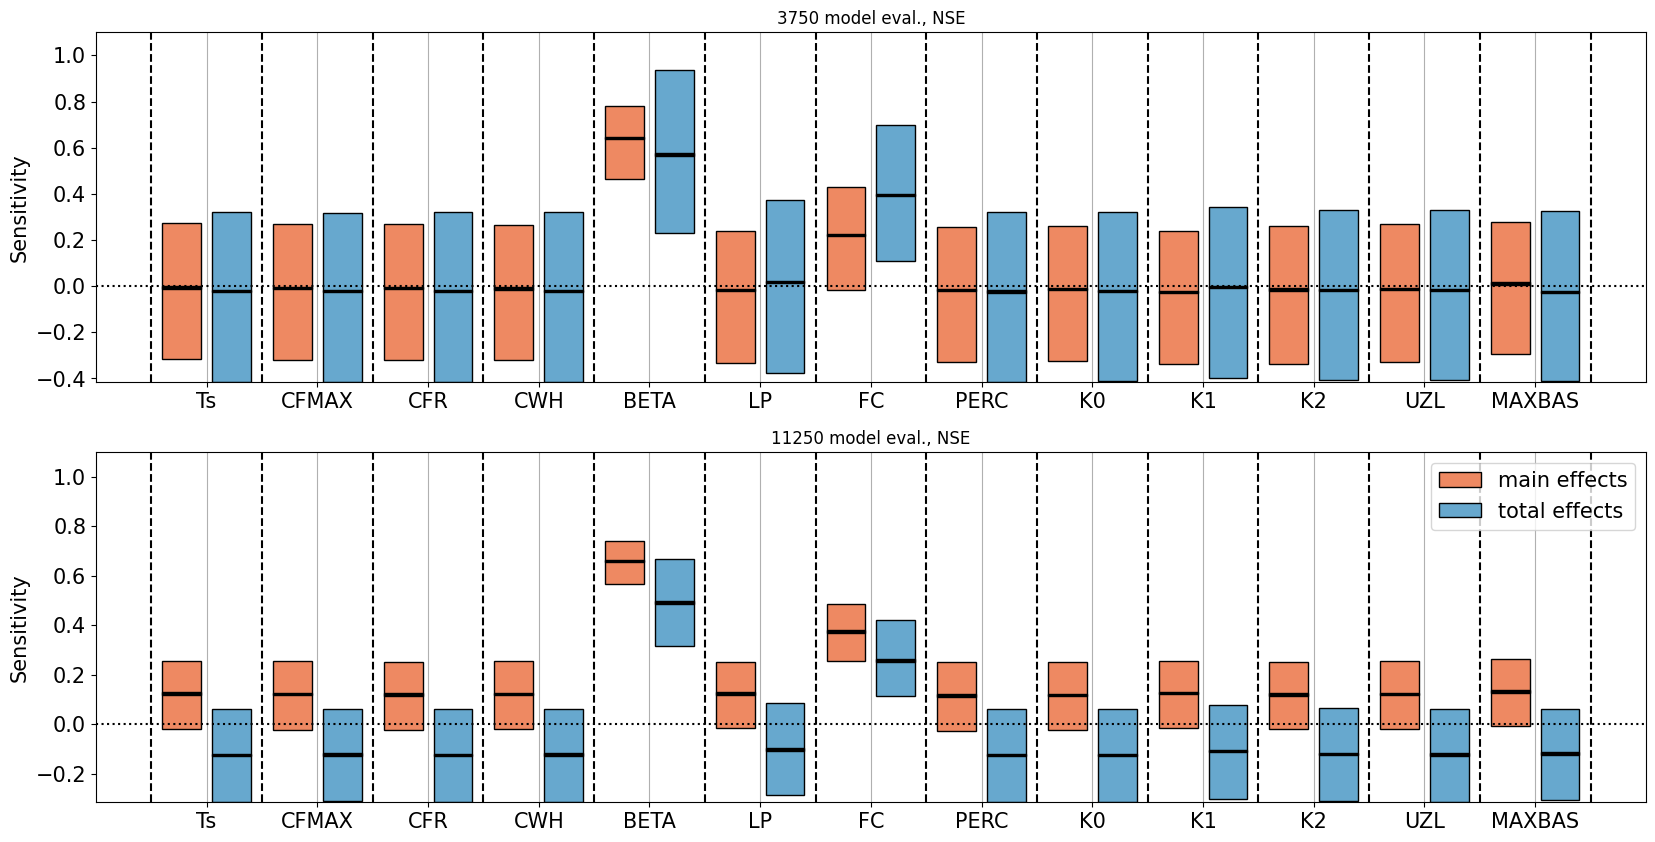

In [9]:
n_samples_new = 500 # increase of base sample size
# (that means: n_samples_new*(n_parameters+2) new samples that will need to be evaluated)
parameter_sets_extended = AAT_sampling_extend(parameter_sets, distr_fun, distr_par, 2*(n_samples+n_samples_new)) # extended sample
# (it includes the already evaluated samples and the new ones)
parameter_sets_new = parameter_sets_extended[2*n_samples:2*(n_samples+n_samples_new), :] # extract the new input samples that need to be evaluated

# Resampling strategy:
print("Resampling using extended set of samples")
[parameter_sets_A_new, parameter_sets_B_new, parameter_sets_C_new] = VBSA.vbsa_resampling(parameter_sets_new)
# Evaluate model against new samples:
print("Executing models (1/3): this might take a while")
errors_A_new = np.nan * np.ones(parameter_sets_A_new.shape[0]) 
for i, parameter_set_A_new in enumerate(parameter_sets_A_new):
    errors_A_new[i], _ = hbv_and_one_obj_fun(parameter_set_A_new, P, T, PET, Q_obs, n_spinup_days, calc_nse)
# should have shape (n_samples_new, 1)
print("Executing models (2/3): wait")
errors_B_new = np.nan * np.ones(parameter_sets_B_new.shape[0]) 
for i, parameter_set_B_new in enumerate(parameter_sets_B_new):
    errors_B_new[i], _ = hbv_and_one_obj_fun(parameter_set_B_new, P, T, PET, Q_obs, n_spinup_days, calc_nse)
# should have shape (n_samples_new, 1)
print("Executing models (3/3): almost done")
errors_C_new = np.nan * np.ones(parameter_sets_C_new.shape[0]) 
for i, parameter_set_C_new in enumerate(parameter_sets_C_new):
    errors_C_new[i], _ = hbv_and_one_obj_fun(parameter_set_C_new, P, T, PET, Q_obs, n_spinup_days, calc_nse)
# should have shape (n_samples_new*n_parameters, 1)

print("Combining new and old results")
errors_A_2 = np.concatenate((errors_A, errors_A_new))  # should have shape (n_samples+n_samples_new, 1)
errors_B_2 = np.concatenate((errors_B, errors_B_new))  # should have shape (n_samples+n_samples_new,1)
errors_C_2 = np.concatenate((np.reshape(errors_C, (n_parameters, n_samples)), np.reshape(errors_C_new, (n_parameters, n_samples_new))),
                             axis=1)# should have size (n_parameters, n_samples+n_samples_new)
errors_C_2 = errors_C_2.flatten() # should have size ((n_samples+n_samples_new)*n_parameters, )

print("Recomputing indices with bootstrap")
n_boot = 1000
sobol_main_2, sobol_total_2 = VBSA.vbsa_indices(errors_A_2, errors_B_2, errors_C_2, n_parameters, n_boot)

print("Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples")
sobol_main_2_m, sobol_main_2_lb, sobol_main_2_ub = aggregate_boot(sobol_main_2) # shape (n_parameters,)
sobol_total_2_m, sobol_total_2_lb, sobol_total_2_ub = aggregate_boot(sobol_total_2) # shape (n_parameters,)

print("Sensitivity indices calculated with the initial sample size (left) and the extended sample size (right)")
plt.figure(figsize=(20,10))
plt.subplot(211)
pf.boxplot2(np.stack((sobol_main_m, sobol_total_m)), S_lb=np.stack((sobol_main_lb, sobol_total_lb)),
            S_ub=np.stack((sobol_main_ub, sobol_total_ub)), X_Labels=parameter_names)
plt.title('%d' % (n_samples*(n_parameters+2)) + ' model eval., NSE')
plt.subplot(212)
pf.boxplot2(np.stack((sobol_main_2_m, sobol_total_2_m)), S_lb=np.stack((sobol_main_2_lb, sobol_total_2_lb)),
            S_ub=np.stack((sobol_main_2_ub, sobol_total_2_ub)), X_Labels=parameter_names,
            legend=['main effects', 'total effects'])
plt.title('%d' % ((n_samples+n_samples_new)*(n_parameters+2)) + ' model eval., NSE')
plt.show()

---

<div class="blue"><span style="color:blue">Exercise section</span></div>
Exercise 3

a) In what ways does the result change between the different sample sizes?

---

#### 2.1.4 Sobol with multiple objective functions 

**Using multiple objective functions (RMSE, bias, correlation)**

Executing models (1/3): this might take a while
Executing models (2/3): wait
Executing models (3/3): almost done
Computing sensitivity indices
Computing mean and confidence intervals of the sensitivity indices across the bootstrap resamples


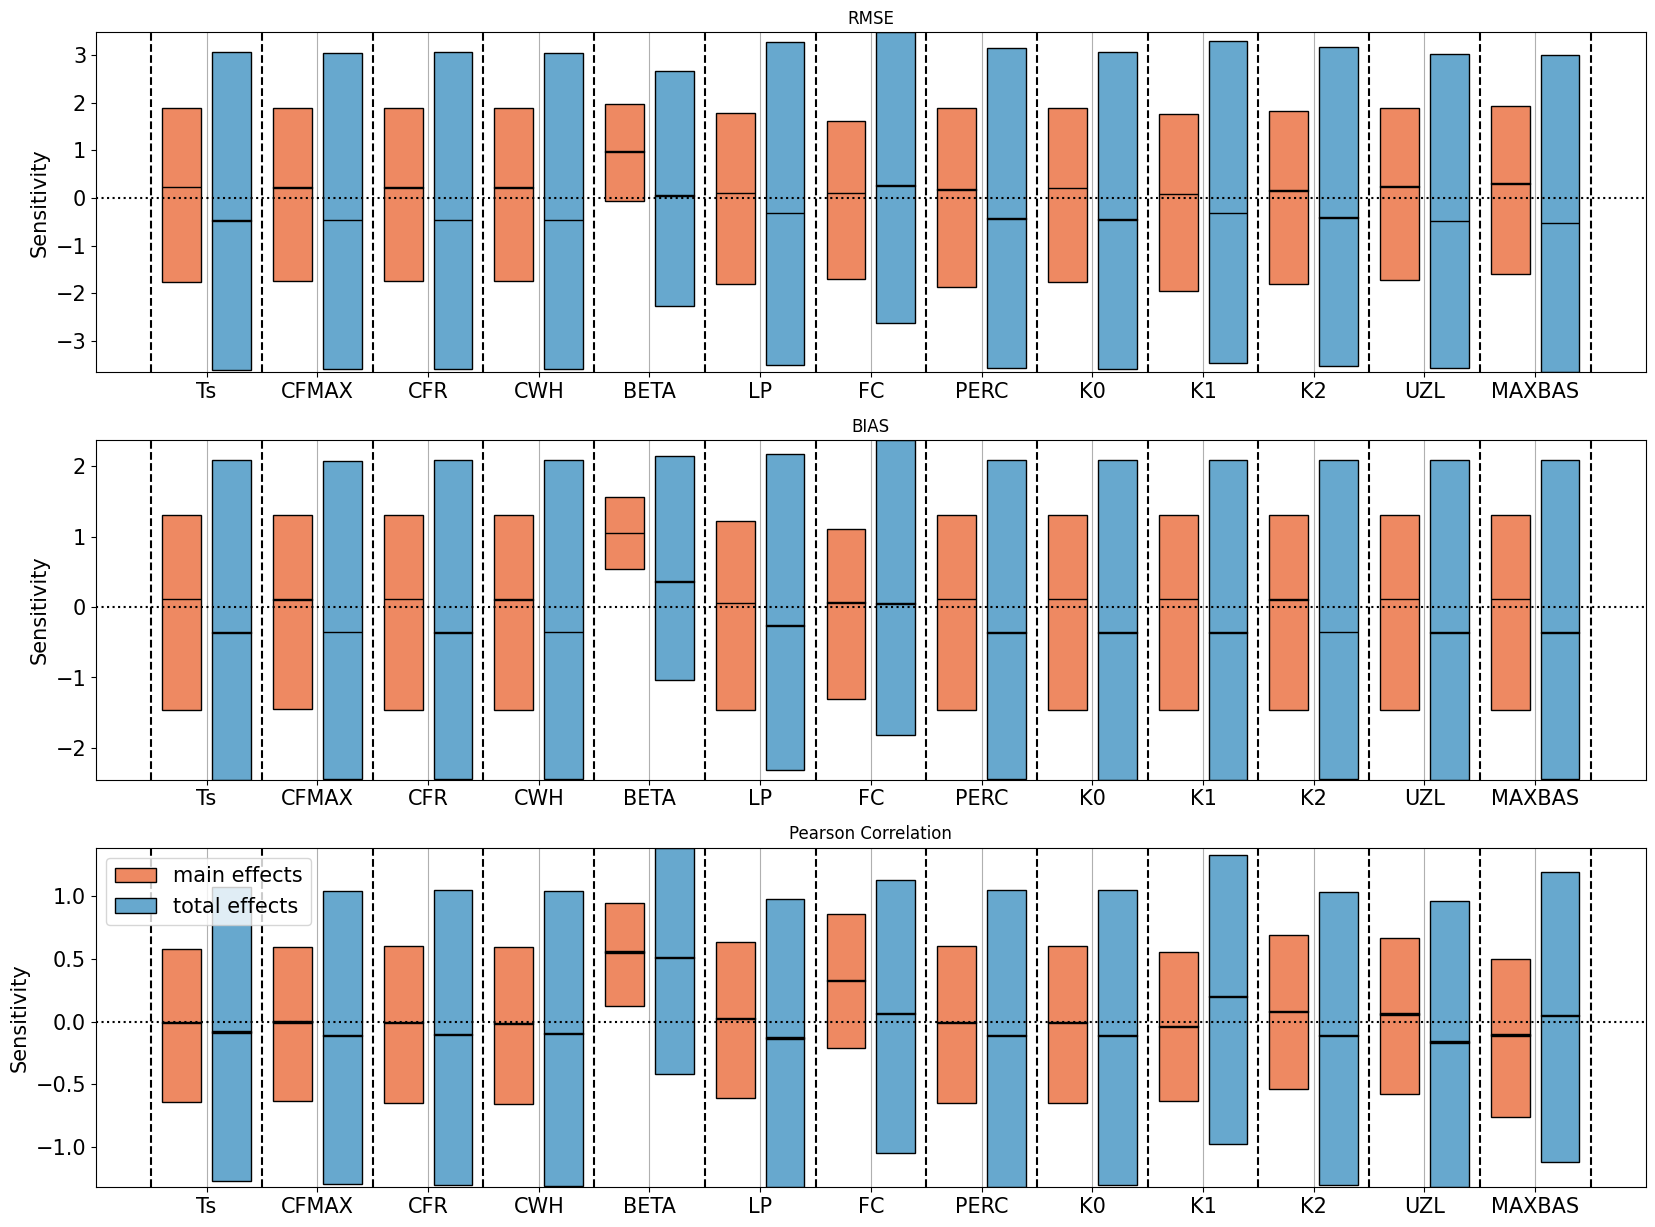

In [10]:
print("Executing models (1/3): this might take a while")
errors_A_mulobj = np.nan * np.ones((parameter_sets_A.shape[0], 3))
for i, parameter_set_A in enumerate(parameter_sets_A):
    (errors_A_mulobj[i,0], errors_A_mulobj[i,1], errors_A_mulobj[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set_A, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)
print("Executing models (2/3): wait")
errors_B_mulobj = np.nan * np.ones((parameter_sets_B.shape[0], 3))
for i, parameter_set_B in enumerate(parameter_sets_B):
    (errors_B_mulobj[i,0], errors_B_mulobj[i,1], errors_B_mulobj[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set_B, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)
print("Executing models (3/3): almost done")
errors_C_mulobj = np.nan * np.ones((parameter_sets_C.shape[0], 3)) 
for i, parameter_set_C in enumerate(parameter_sets_C):
    (errors_C_mulobj[i,0], errors_C_mulobj[i,1], errors_C_mulobj[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set_C, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)

print("Computing sensitivity indices")
n_boot = 1000
sobol_main_1, sobol_total_1 = VBSA.vbsa_indices(errors_A_mulobj[:, 0], errors_B_mulobj[:, 0], errors_C_mulobj[:, 0], n_parameters, n_boot)
sobol_main_2, sobol_total_2 = VBSA.vbsa_indices(errors_A_mulobj[:, 1], errors_B_mulobj[:, 1], errors_C_mulobj[:, 1], n_parameters, n_boot)
sobol_main_3, sobol_total_3 = VBSA.vbsa_indices(errors_A_mulobj[:, 2], errors_B_mulobj[:, 2], errors_C_mulobj[:, 2], n_parameters, n_boot)

print("Computing mean and confidence intervals of the sensitivity indices across the bootstrap resamples")
sobol_main_1_m, sobol_main_1_lb, sobol_main_1_ub = aggregate_boot(sobol_main_1) # shape (n_parameters, )
sobol_total_1_m, sobol_total_1_lb, sobol_total_1_ub = aggregate_boot(sobol_total_1) # shape (n_parameters, )
sobol_main_2_m, sobol_main_2_lb, sobol_main_2_ub = aggregate_boot(sobol_main_2) # shape (n_parameters, )
sobol_total_2_m, sobol_total_2_lb, sobol_total_2_ub = aggregate_boot(sobol_total_2) # shape (n_parameters, )
sobol_main_3_m, sobol_main_3_lb, sobol_main_3_ub = aggregate_boot(sobol_main_3) # shape (n_parameters, )
sobol_total_3_m, sobol_total_3_lb, sobol_total_3_ub = aggregate_boot(sobol_total_3) # shape (n_parameters, )

# Compare boxplots:
plt.figure(figsize=(20,15))
plt.subplot(311)
pf.boxplot2(np.stack((sobol_main_1_m, sobol_total_1_m)), S_lb=np.stack((sobol_main_1_lb, sobol_total_1_lb)),
            S_ub=np.stack((sobol_main_1_ub, sobol_total_1_ub)), X_Labels=parameter_names)
plt.title('RMSE')
plt.subplot(312)
pf.boxplot2(np.stack((sobol_main_2_m, sobol_total_2_m)), S_lb=np.stack((sobol_main_2_lb, sobol_total_2_lb)),
            S_ub=np.stack((sobol_main_2_ub, sobol_total_2_ub)), X_Labels=parameter_names)
plt.title('BIAS')
plt.subplot(313)
pf.boxplot2(np.stack((sobol_main_3_m, sobol_total_3_m)), S_lb=np.stack((sobol_main_3_lb, sobol_total_3_lb)),
            S_ub=np.stack((sobol_main_3_ub, sobol_total_3_ub)), X_Labels=parameter_names,
            legend=['main effects', 'total effects'])
plt.title('Pearson Correlation')
plt.show()

---

<div class="blue"><span style="color:blue">Exercise section</span></div>
Exercise 4

a) What influence do the objective functions (NSE, RMSE, bias, correlation) have on the sensitivity?

* Answer

---

#### 2.1.5 Sobol with a dummy parameter

**Adding a dummy parameter to Sobol method**

Executing models (1/3): this might take a while
Executing models (2/3): wait
Executing models (3/3): almost done
Computing main (first-order) and total effects
Main effects, total effects and interactions in different plots:


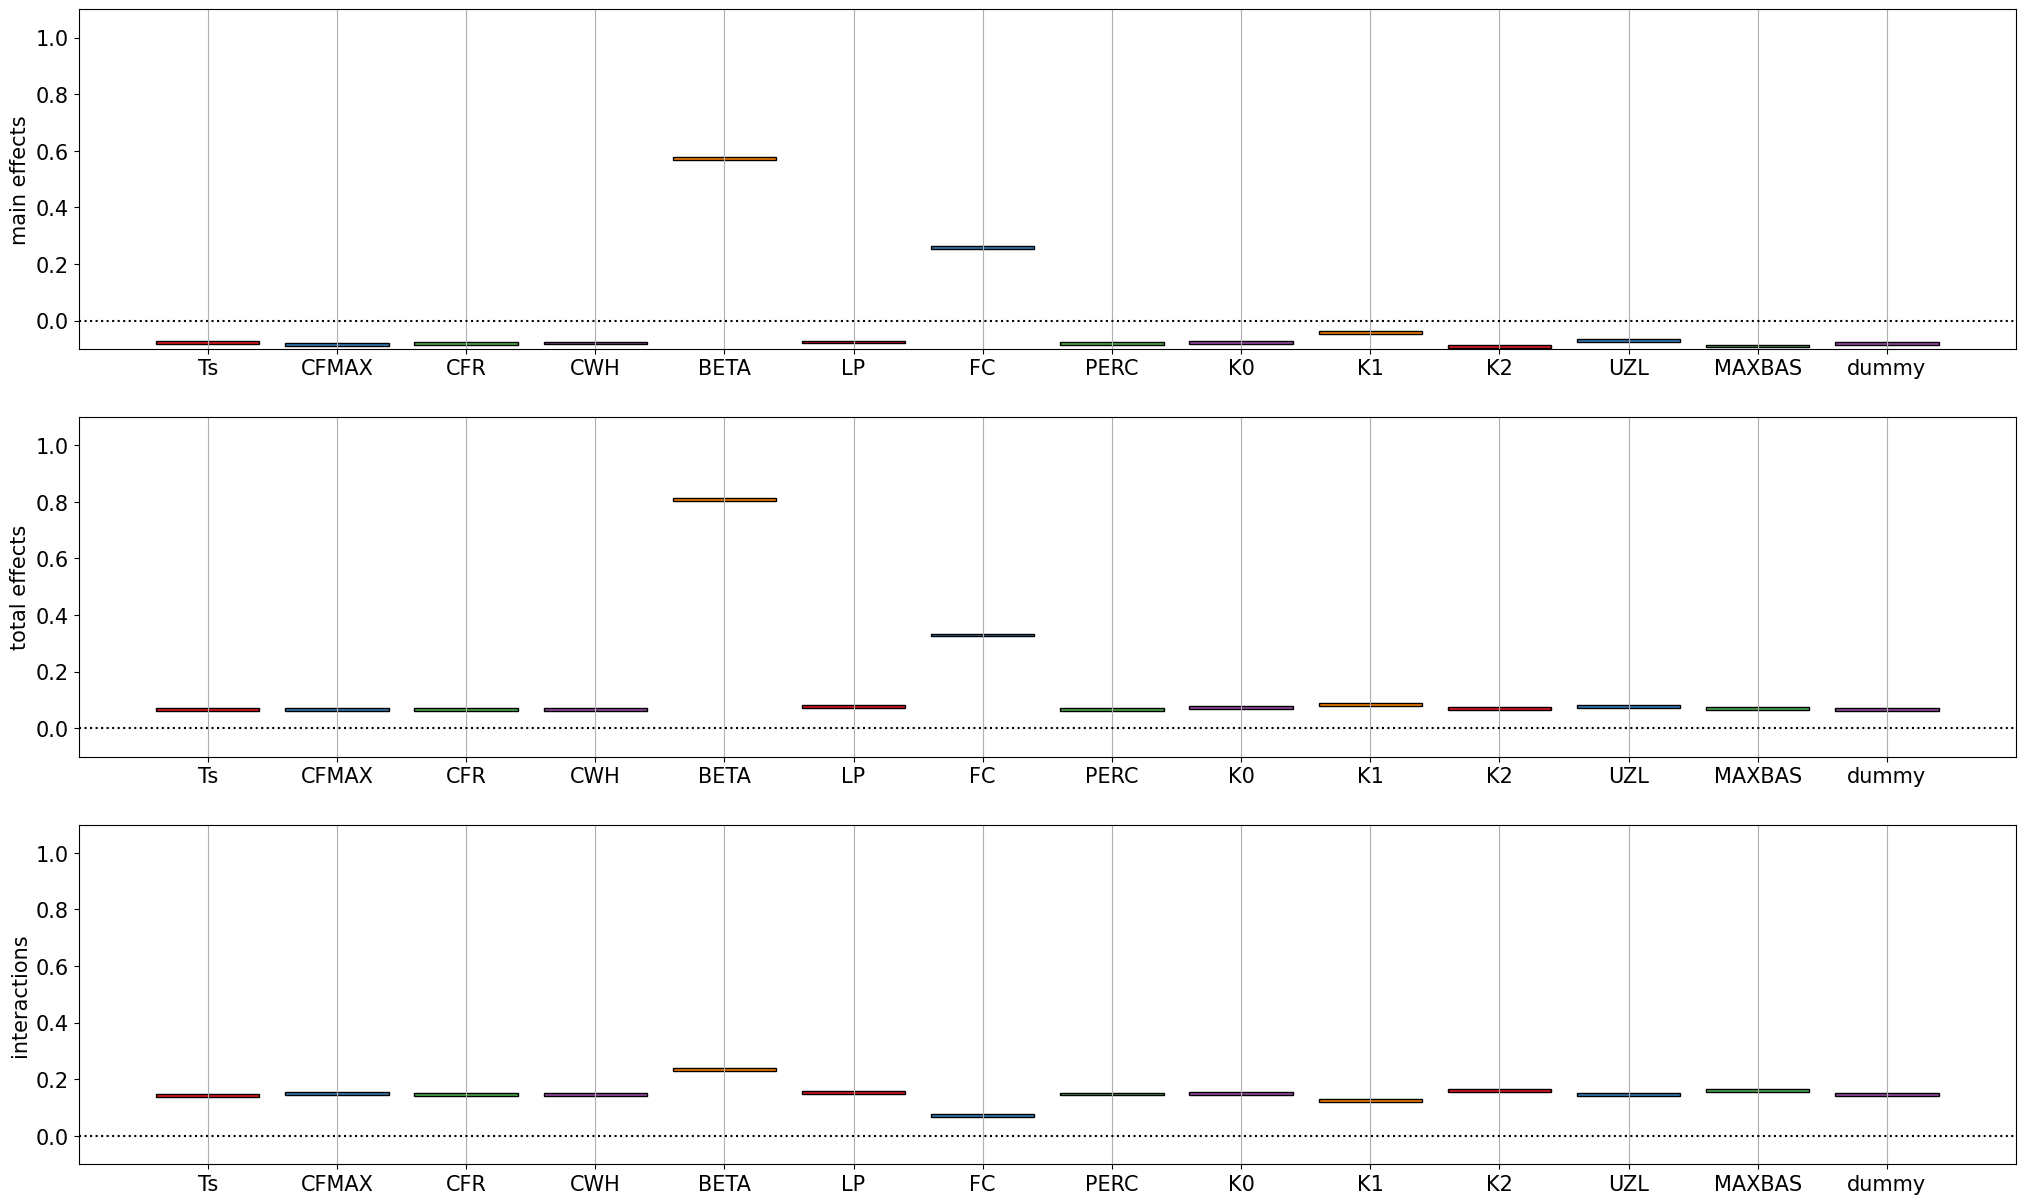

In [11]:
# define distribution
parameter_names_dummy = parameter_names + ["dummy"]
n_parameters_dummy = n_parameters + 1
xmin_dummy = xmin + [0]
xmax_dummy = xmax + [1]
distr_fun_dummy = st.uniform # uniform distribution
distr_par_dummy = [np.nan] * n_parameters_dummy
for i in range(n_parameters_dummy):
    distr_par_dummy[i] = [xmin_dummy[i], xmax_dummy[i] - xmin_dummy[i]]

parameter_sets_dummy = AAT_sampling(sampling_strategy, n_parameters_dummy, distr_fun_dummy, distr_par_dummy, 2*n_samples)
parameter_sets_A_dummy, parameter_sets_B_dummy, parameter_sets_C_dummy = VBSA.vbsa_resampling(parameter_sets_dummy)

print("Executing models (1/3): this might take a while")
errors_A_dummy = np.nan * np.ones(parameter_sets_A_dummy.shape[0]) 
for i, parameter_set_A_dummy in enumerate(parameter_sets_A_dummy):
    errors_A_dummy[i], _ = hbv_and_one_obj_fun(parameter_set_A_dummy, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Executing models (2/3): wait")
errors_B_dummy = np.nan * np.ones(parameter_sets_B_dummy.shape[0]) 
for i, parameter_set_B_dummy in enumerate(parameter_sets_B_dummy):
    errors_B_dummy[i], _ = hbv_and_one_obj_fun(parameter_set_B_dummy, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Executing models (3/3): almost done")
errors_C_dummy = np.nan * np.ones(parameter_sets_C_dummy.shape[0]) 
for i, parameter_set_C_dummy in enumerate(parameter_sets_C_dummy):
    errors_C_dummy[i], _ = hbv_and_one_obj_fun(parameter_set_C_dummy, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Computing main (first-order) and total effects")
sobol_main_dummy, sobol_total_dummy = VBSA.vbsa_indices(errors_A_dummy, errors_B_dummy, errors_C_dummy, n_parameters_dummy)

print("Main effects, total effects and interactions in different plots:")
plt.figure(figsize=(25,15)) # plot main, total and interaction effects separately
plt.subplot(311)
pf.boxplot1(sobol_main_dummy, X_Labels=parameter_names_dummy, Y_Label='main effects')
plt.subplot(312)
pf.boxplot1(sobol_total_dummy, X_Labels=parameter_names_dummy, Y_Label='total effects')
plt.subplot(313)
pf.boxplot1(sobol_total_dummy-sobol_main_dummy, X_Labels=parameter_names_dummy, Y_Label='interactions')
plt.show()

### 2.2 PAWN

**Using multiple objective functions (RMSE, bias, correlation) for PAWN**

Executing models: this might take a while
Computing PAWN sensitivity indices


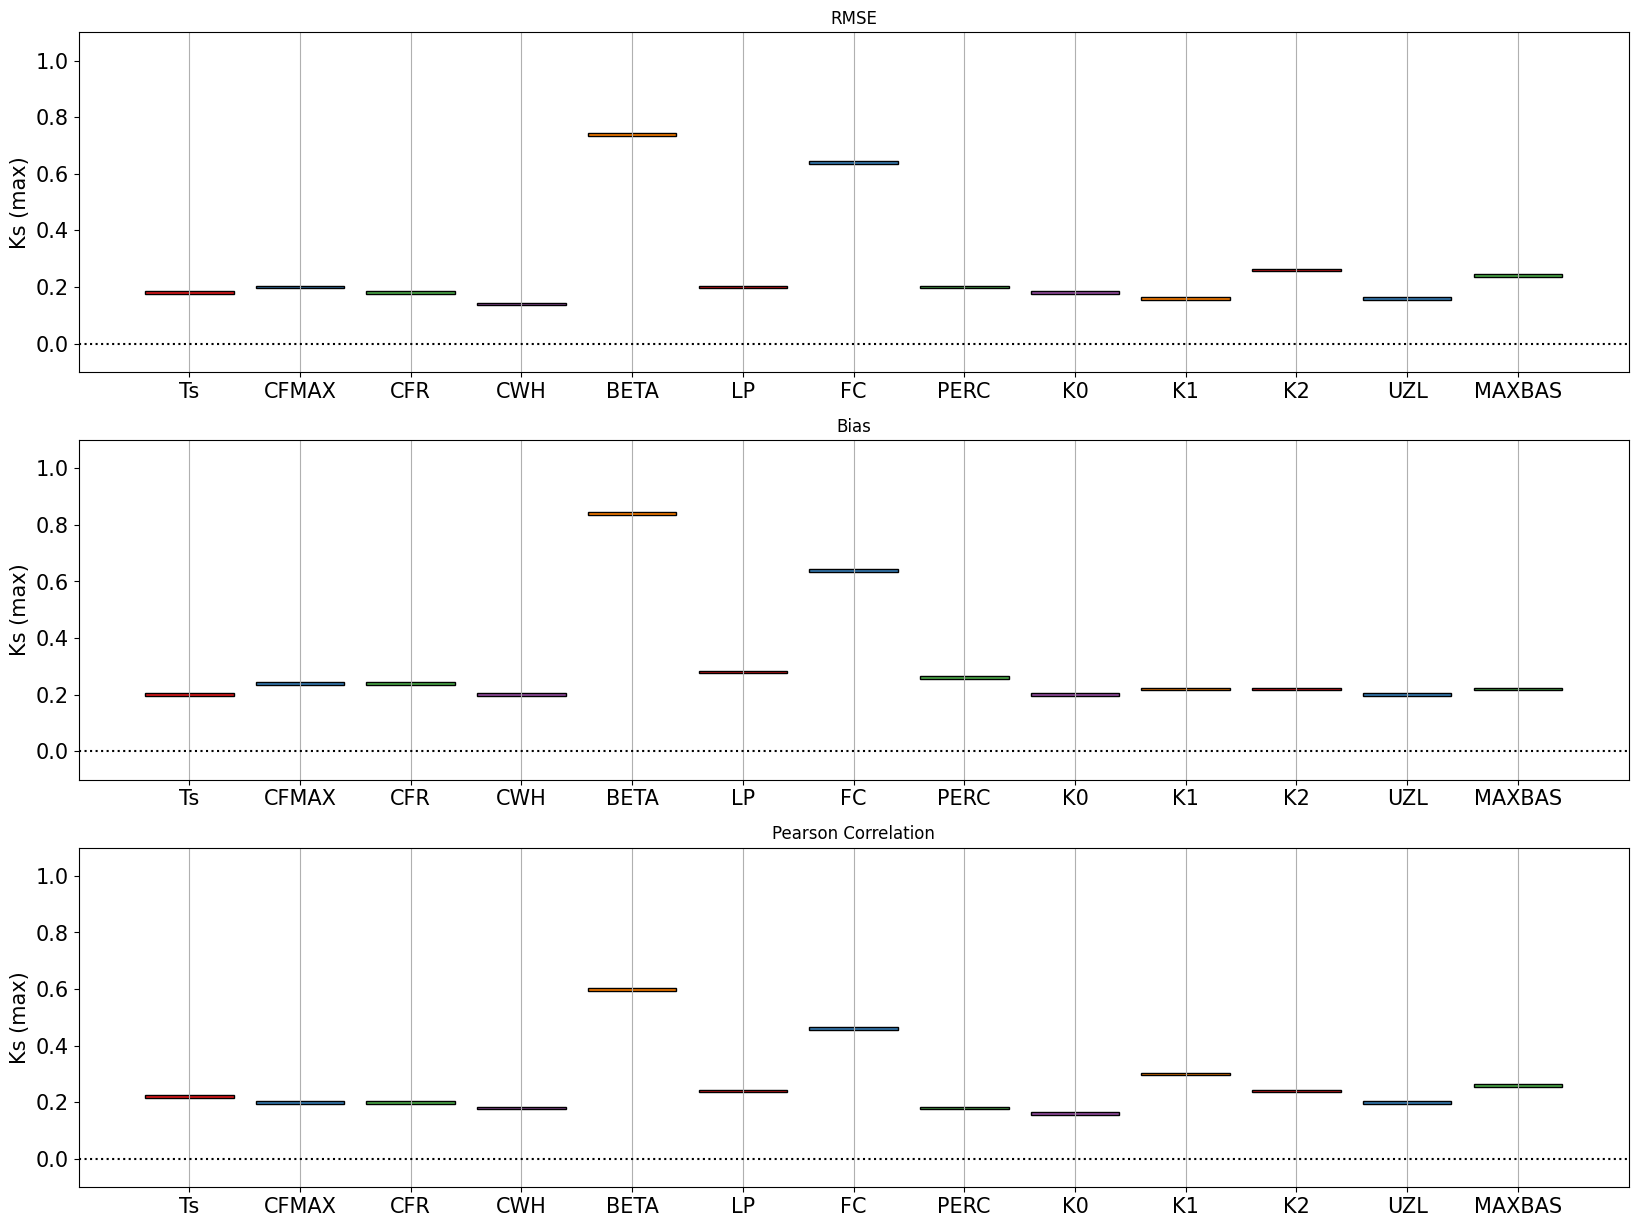

In [12]:
n_pawn = 10

print("Executing models: this might take a while")
errors_pawn = np.nan * np.ones((parameter_sets.shape[0], 3))
for i, parameter_set in enumerate(parameter_sets):
    (errors_pawn[i,0], errors_pawn[i,1], errors_pawn[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)

print("Computing PAWN sensitivity indices")
KS_rmse_median, KS_rmse_mean, KS_rmse_max = PAWN.pawn_indices(parameter_sets, errors_pawn[:,0], n_pawn)
KS_bias_median, KS_bias_mean, KS_bias_max = PAWN.pawn_indices(parameter_sets, errors_pawn[:,1], n_pawn)
KS_corr_median, KS_corr_mean, KS_corr_max = PAWN.pawn_indices(parameter_sets, errors_pawn[:,2], n_pawn)
# Plot results:
plt.figure(figsize=(20,15))
plt.subplot(311)
pf.boxplot1(KS_rmse_max, X_Labels=parameter_names, Y_Label='Ks (max)')
plt.title('RMSE')
plt.subplot(312)
pf.boxplot1(KS_bias_max, X_Labels=parameter_names, Y_Label='Ks (max)')
plt.title('Bias')
plt.subplot(313)
pf.boxplot1(KS_corr_max, X_Labels=parameter_names, Y_Label='Ks (max)')
plt.title('Pearson Correlation')
plt.show()

---

<div class="blue"><span style="color:blue">Exercise section</span></div>
Exercise 5

a) Look at the sensitivity indices of the dummy parameter. What does that imply for the acutal model parameters with similar or lower sensitivity?

* Answer

---

### 2.3 Investigating interactions of parameters

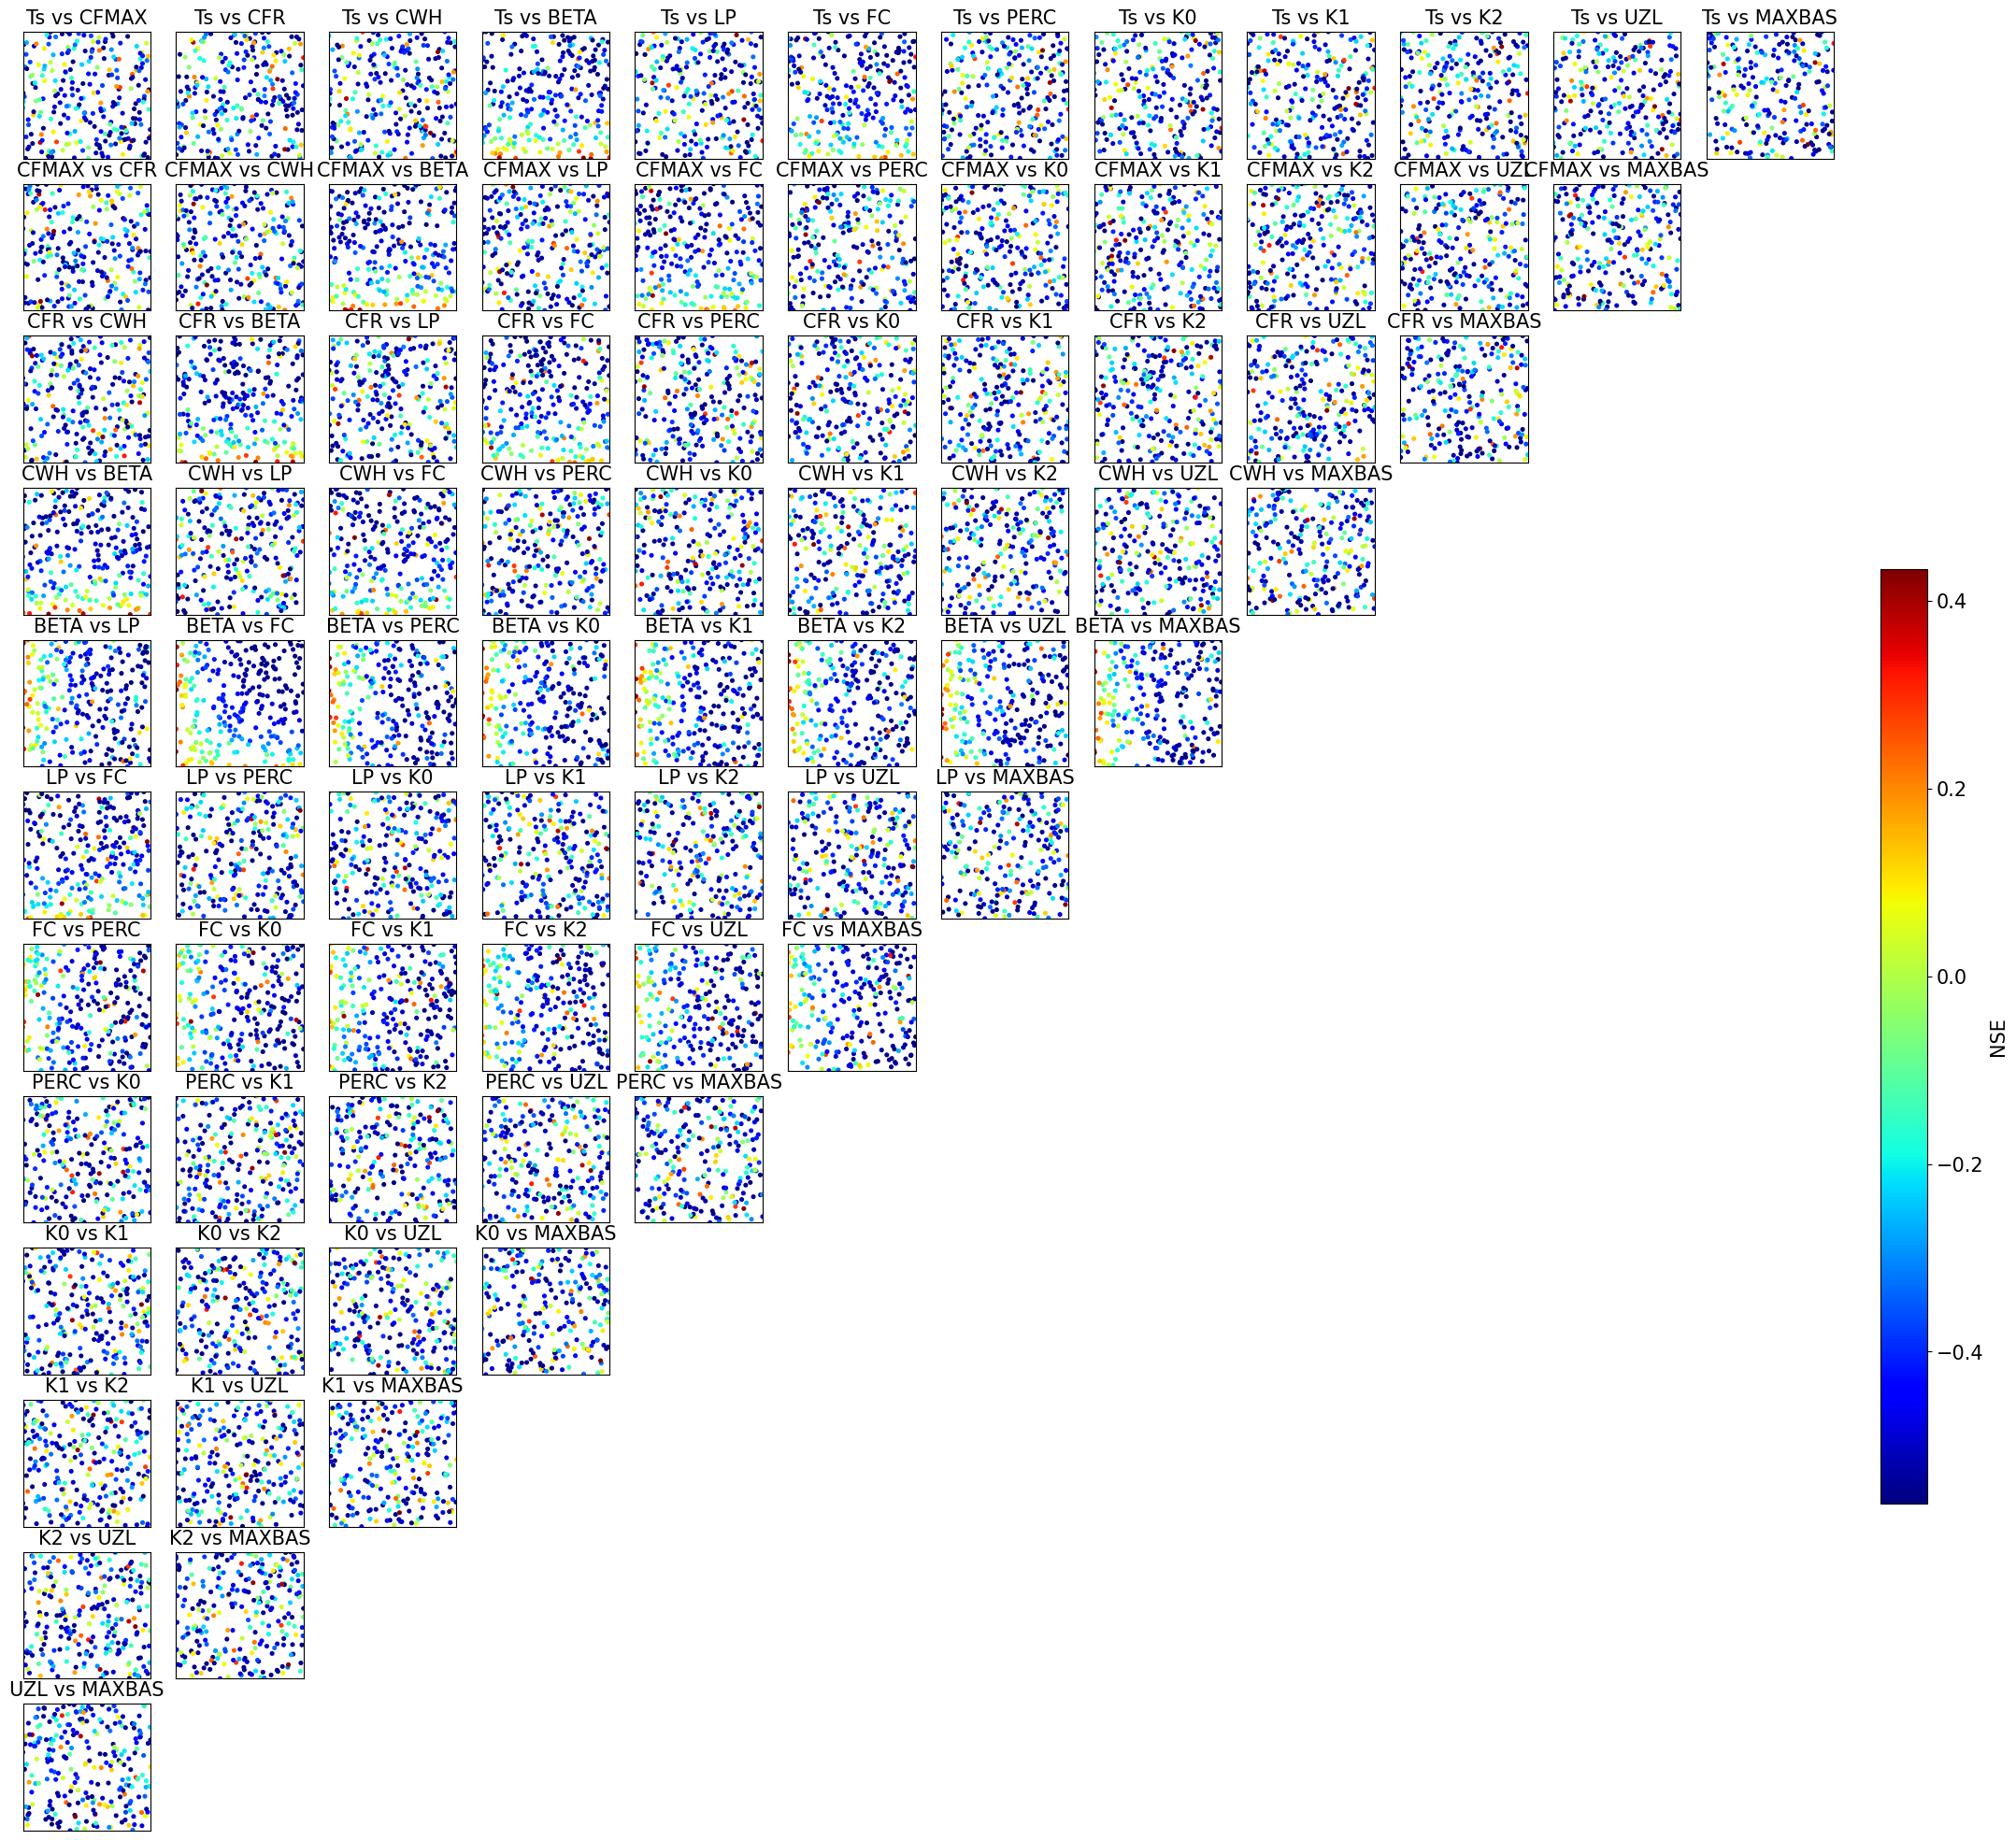

In [13]:
pf.scatter_plots_interaction(parameter_sets_A, errors_A, X_Labels=parameter_names, Y_Label="NSE")
plt.show()

---

<div class="blue"><span style="color:blue">Exercise section</span></div>
Exercise 6

a) Look at the interaction plots. Does it represent what you expected from looking at the interactions you got from using the Sobol method? 

* Answer

b) Which parameters interact most, and can you point out why (looking at the model structure)?

* Answer

---

## Jupyter format settings

In [14]:
%%html 
<style>.blue {background-color: #8dc9fc;}</style>